In [1]:
import cem_mini
import matplotlib.pyplot as plt
import numpy as np

# the bridge topology

In [2]:
def bridge_topology(nr,
                    length = 10,
                    width = 10,
                    height = -4,
                    left_dev_mags = [3,-3],
                    center_dev_mags = [-50,10],
                    right_dev_mags = None,
                    slab_loads = [0,0,-2],
                    no_outer_dev=True):
    '''
    create a bridge from topology like this
    
    <=====1 --- 4 ===> support
         / \   / \
    <===/==2--/--3===> slab 2
    <==0-----5=======> slab 1
    
    where == are the trail edges, -- and / are deviation edges, < and > shows the force flow directions
    
    ---- parameters ----
    nr:              number of nodes per trail paths, must >=2

    length:          a number or cem_mini.samplers.
                     generate the x coord of the inital nodes, also used to generate the constrained planes
                     
    width:           a number or cem_mini.samplers.
                     generate the y coord of the inital nodes

    height:          a number or cem_mini.samplers.
                     generate the z coord of the inital nodes
                     
    left_dev_mags:   list of 2 / 3 / 6 elements. The elements can be either
                     numbers or cem_mini.samplers.
                     
                     when 6 elements [A1, B1, C1, A2, B2, C2] are given,
                     [A1, A2] will be used as the start and end dev_mag between slab 1 and slab 2,
                     [B1, B2] will be used as the start and end dev_mag between slab 1 and support,
                     [C1, C2] will be used as the start and end dev_mag between slab 2 and support,
                     
                     when 3 elements [A, B, C] are given,
                     A will generate [A1, A2], B for [B1, B2], and C for [C1, C2]
                     
                     when 2 elements [A, B] are given,
                     A will generate [A1, A2], B for [B1, B2], and C1 = B1, C2 = B2
                     
    center_dev_mags: list of 2 / 3 elements.
                     The elements can be either numbers or cem_mini.samplers.
                     
                     when 3 elements [A, B, C] are given,
                     A will be the dev_mag of edge [1-4]
                     B will be the dev_mag of edge [0-5]
                     C will be the dev_mag of edge [2-3]
                     
                     when 2 elements [A, B] are given, C = B
                     
    right_dev_mags:  same definition of left_dev_mags,
                     except that it controls the right side of the bridge.
                     If None is given, the left_dev_mags will be used (symmitrical bridge)
    
    slab_loads:      loads (list of 3 numbers) of all slab nodes
    
    '''
    
    nt=6 # 6 trail paths
    
    # axial graph with 6 trail edges
    # 1 - 4 will be the support (arch or cable)
    # 0 - 5 will be one side of the slab
    # 2 - 3 will be another side of the slab
    graph = cem_mini.axial_graph(nt,nr, [(0, 1), (1, 2), (2, 0), (3, 4), (4, 5), (5, 3)], no_outer_dev)
    
    # sample the l, w, h values
    if hasattr(length,'__call__'):
        length=length()
        
    if hasattr(width,'__call__'):
        width=width()
        
    if hasattr(height,'__call__'):
        height=height()
    
    # sampling left_dev_mags
    if len(left_dev_mags)==2 or len(left_dev_mags)==3 or len(left_dev_mags)==6:
        if len(left_dev_mags)==2:
            # A, B, B, A, B, B
            left_dev_mags=[left_dev_mags[0], left_dev_mags[1], left_dev_mags[1], left_dev_mags[0], left_dev_mags[1], left_dev_mags[1]]
        elif len(left_dev_mags)==3:
            # A, B, C, A, B, C
            left_dev_mags=left_dev_mags + left_dev_mags
        
        # convert to number if sampler is given
        left_dev_mags=[i() if hasattr(i,'__call__') else i for i in left_dev_mags]
    else:
        raise Exception ('left_dev_mags must have a length of 2, 3 or 6')
    
    if len(center_dev_mags)==2:
        center_dev_mags=[center_dev_mags[0],center_dev_mags[1],center_dev_mags[1]]
    
    if len(center_dev_mags)==3:
        center_dev_mags=[i() if hasattr(i,'__call__') else i for i in center_dev_mags]
    else:
        raise Exception ('center_dev_mags must have a length of 2 or 3')
    
    # sampling right_dev_mags
    if right_dev_mags is None:
        right_dev_mags = left_dev_mags
    else:
        if len(right_dev_mags)==2 or len(right_dev_mags)==3 or len(right_dev_mags)==6:
            if len(right_dev_mags)==2:
                # A, B, B, A, B, B
                right_dev_mags=[right_dev_mags[0], right_dev_mags[1], right_dev_mags[1], right_dev_mags[0], right_dev_mags[1], right_dev_mags[1]]
            elif len(right_dev_mags)==3:
                # A, B, C, A, B, C
                right_dev_mags=right_dev_mags + right_dev_mags

            # convert to number if sampler is given
            right_dev_mags=[i() if hasattr(i,'__call__') else i for i in right_dev_mags]
        else:
            raise Exception ('right_dev_mags must have a length of 2, 3 or 6')
    
    num_nodes=graph['num_nodes']
    trail_paths=graph['trail_paths']
    
    # trail lengths will be overrided by contrained planes, therefore the values do not matter
    trail_length = [[0.1] * (nr-1)] * 6

    # in addition, deviation edges [[0, 5], [1, 4], [2, 3]] will be added
    # to connect the trail paths and the deviation edges of the two sides of the bridge
    deviation_edges=graph['deviation_edges'] + [(0, 5), (1, 4), (2, 3)]
    dev_force_mag = np.zeros(len(deviation_edges), dtype=np.float32) # default dev force mag
    
    # retrieve deviation edge indexes and the generate the corresponding dev_mag values
    # a linear interpolation will be made for the dev_mag if start != end
    left_support_slab1 = [i * 6 for i in range((nr - 1) if no_outer_dev else nr)]
    left_support_slab1_dev = np.linspace(left_dev_mags[1], left_dev_mags[4], (nr - 1) if no_outer_dev else nr)
    
    left_support_slab2 = [i * 6 + 1 for i in range((nr - 1) if no_outer_dev else nr)]
    left_support_slab2_dev = np.linspace(left_dev_mags[2], left_dev_mags[5], (nr - 1) if no_outer_dev else nr)
    
    left_slab1_slab2 = [i * 6 + 2 for i in range((nr - 1) if no_outer_dev else nr)]
    left_slab1_slab2_dev = np.linspace(left_dev_mags[0], left_dev_mags[3], (nr - 1) if no_outer_dev else nr)
    
    right_support_slab1 = [i * 6 + 4 for i in range((nr - 1) if no_outer_dev else nr)]
    right_support_slab1_dev = np.linspace(right_dev_mags[1], right_dev_mags[4], (nr - 1) if no_outer_dev else nr)
    
    right_support_slab2 = [i * 6 + 3 for i in range((nr - 1) if no_outer_dev else nr)]
    right_support_slab2_dev = np.linspace(right_dev_mags[2], right_dev_mags[5], (nr - 1) if no_outer_dev else nr)
    
    right_slab1_slab2 = [i * 6 + 5 for i in range((nr - 1) if no_outer_dev else nr)]
    right_slab1_slab2_dev = np.linspace(right_dev_mags[0], right_dev_mags[3], (nr - 1) if no_outer_dev else nr)
    
    # assigning the values
    dev_force_mag[left_support_slab1] = left_support_slab1_dev
    dev_force_mag[left_support_slab2] = left_support_slab2_dev
    dev_force_mag[left_slab1_slab2] = left_slab1_slab2_dev
    
    dev_force_mag[right_support_slab1] = right_support_slab1_dev
    dev_force_mag[right_support_slab2] = right_support_slab2_dev
    dev_force_mag[right_slab1_slab2] = right_slab1_slab2_dev
    
    dev_force_mag[-3] = center_dev_mags[1] # edge[0,5], slab1
    dev_force_mag[-2] = center_dev_mags[0] # edge[1,4], support
    dev_force_mag[-1] = center_dev_mags[2] # edge[2,3], slab2
    
    T=cem_mini.create_topology(num_nodes)
    # trail_length will be completely overrided by constrained planes
    cem_mini.set_trail_paths(T, trail_paths, trail_length)
    cem_mini.set_deviation_edges(T,deviation_edges,dev_force_mag)
    
    # initial nodes
    x = length / 2
    y = width / 2
    z = height
    
    node_pos = {
                0:[-x, -y, 0], 1:[-x, 0, z], 2:[-x, y, 0],
                3:[x, y, 0], 4:[x, 0, z], 5:[x, -y, 0],
               }
    
    cem_mini.set_original_node_positions(T,node_pos)
    
    # constrained planes (-x or x direction based on the trail index)
    constrained_planes = {(i*nt+j):[(-x-length*i if j<3 else x+length*i), 0, 0, (-1 if j<3 else 1), 0, 0] for i in range(nr) for j in range(nt)}
    cem_mini.set_constrained_planes(T,constrained_planes)
    
    loads = {(i*nt+j):(slab_loads if j%3!=1 else [0,0,0]) for i in range(nr) for j in range(nt)}
    cem_mini.set_node_loads(T,loads)

    return T

In [3]:
def plot_bridge(F):
    plt.figure(figsize=(16,8))
    ax=plt.axes([0,0,0.5,1], projection='3d')
    cem_mini.plot_cem_form(ax,F['coords'],F['edges'],F['edge_forces'],F['loads'],view='3D-45',thickness_base=0.5,thickness_ratio=0.02,load_len_scale=10)
    plt.axis('on')

    ax=plt.axes([0.5,0,0.5,1], projection='3d')
    cem_mini.plot_cem_form(ax,F['coords'],F['edges'],F['edge_forces'],F['loads'],view='2D-XZ',thickness_base=0.5,thickness_ratio=0.02,load_len_scale=10)
    plt.axis('on')

    plt.show()

# the default bridge

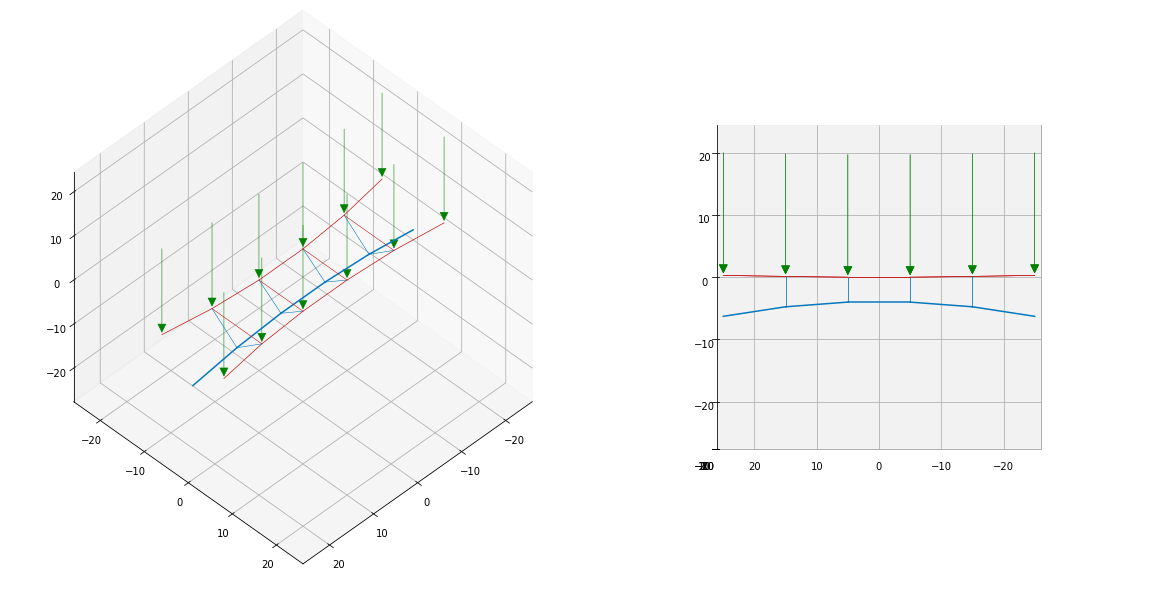

In [4]:
T = bridge_topology(3)

F, Fc= cem_mini.CEM(T,1e-7)

plot_bridge(F)

# variations

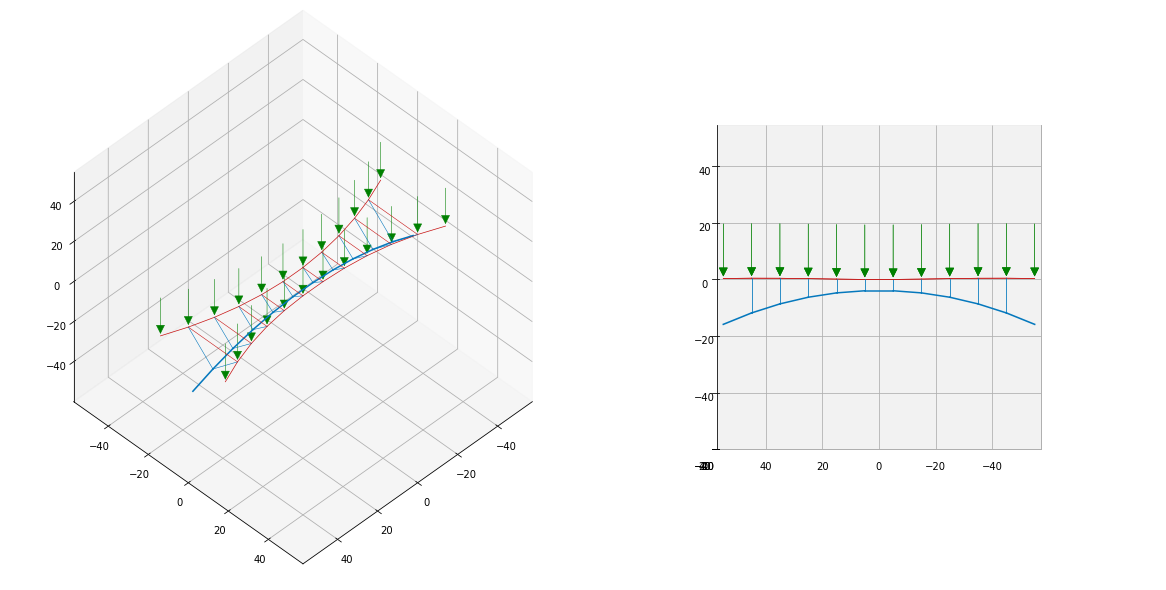

In [5]:
T = bridge_topology(6, left_dev_mags=[3,-3], center_dev_mags=[-50,10], height=-4)

F, Fc= cem_mini.CEM(T,1e-7)

plot_bridge(F)

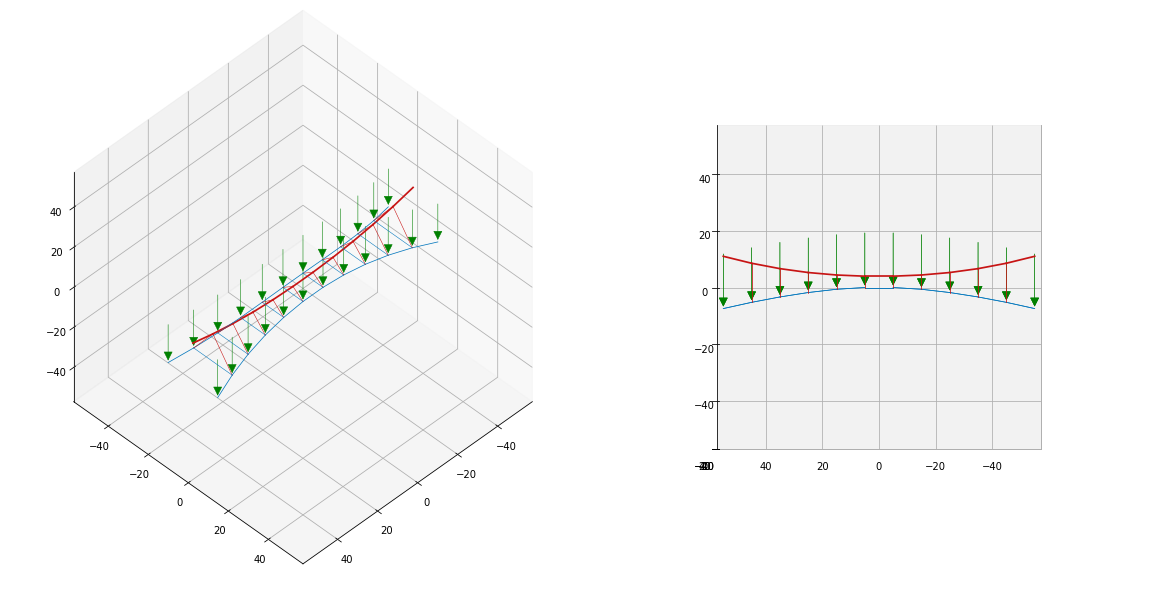

In [6]:
# 
T = bridge_topology(6, left_dev_mags=[-2,2], center_dev_mags=[60,-12], height = 4)

F, Fc= cem_mini.CEM(T,1e-7)

plot_bridge(F)

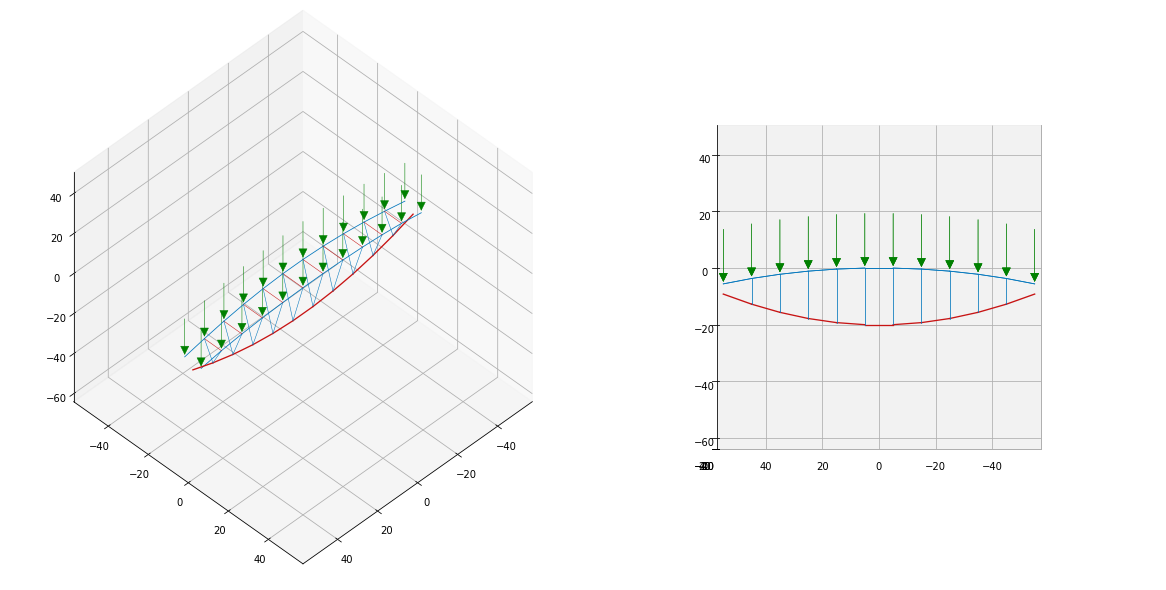

In [7]:
T = bridge_topology(6, left_dev_mags=[0.5,-1.5], center_dev_mags=[40,-15], height=-20)

F, Fc= cem_mini.CEM(T,1e-7)

plot_bridge(F)

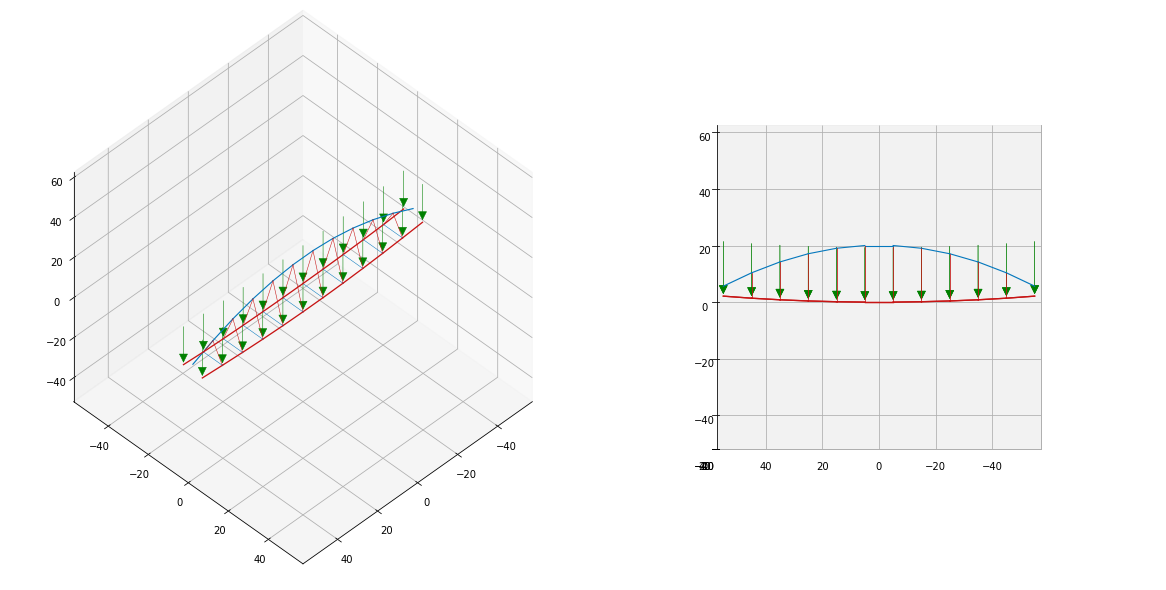

In [8]:
T = bridge_topology(6, left_dev_mags=[-0.5,1.5], center_dev_mags=[-30, 40], height=20)

F, Fc= cem_mini.CEM(T,1e-7)

plot_bridge(F)

# some randomness

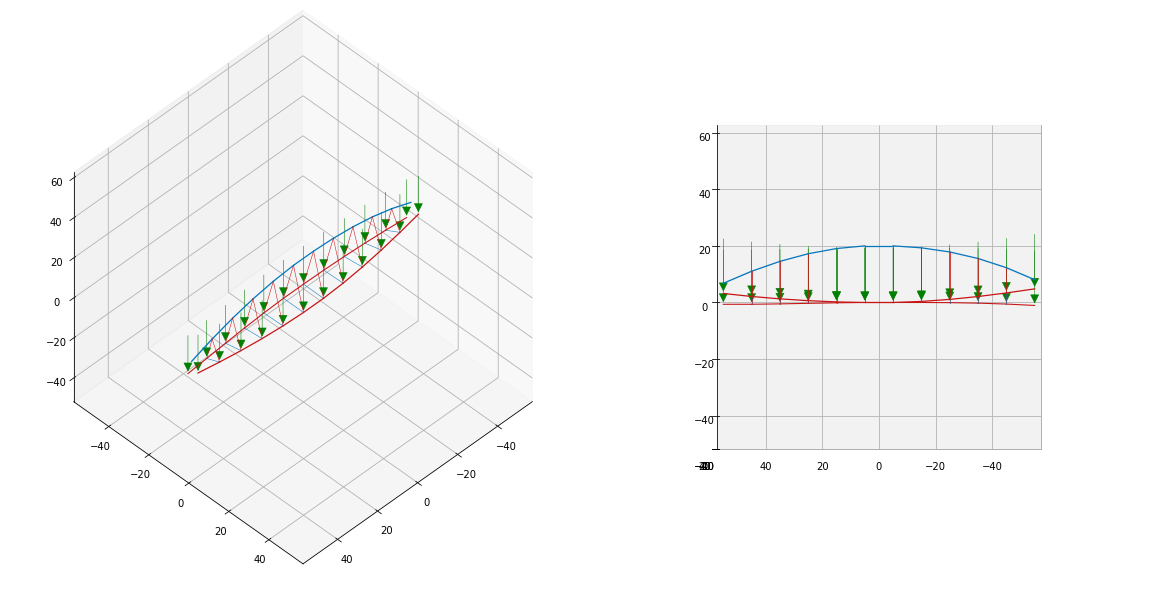

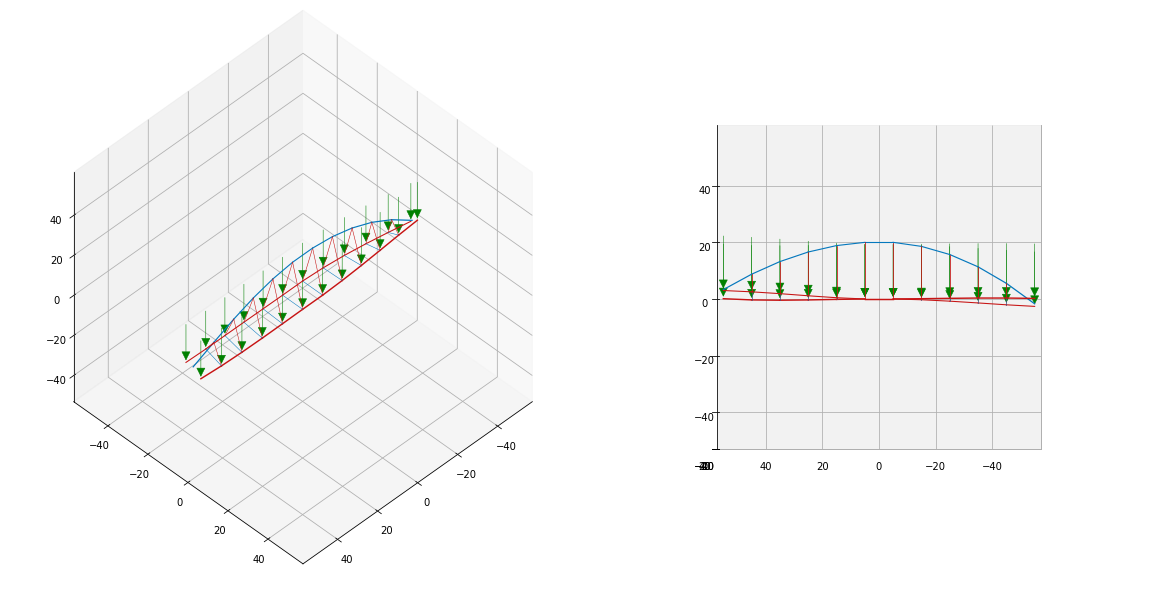

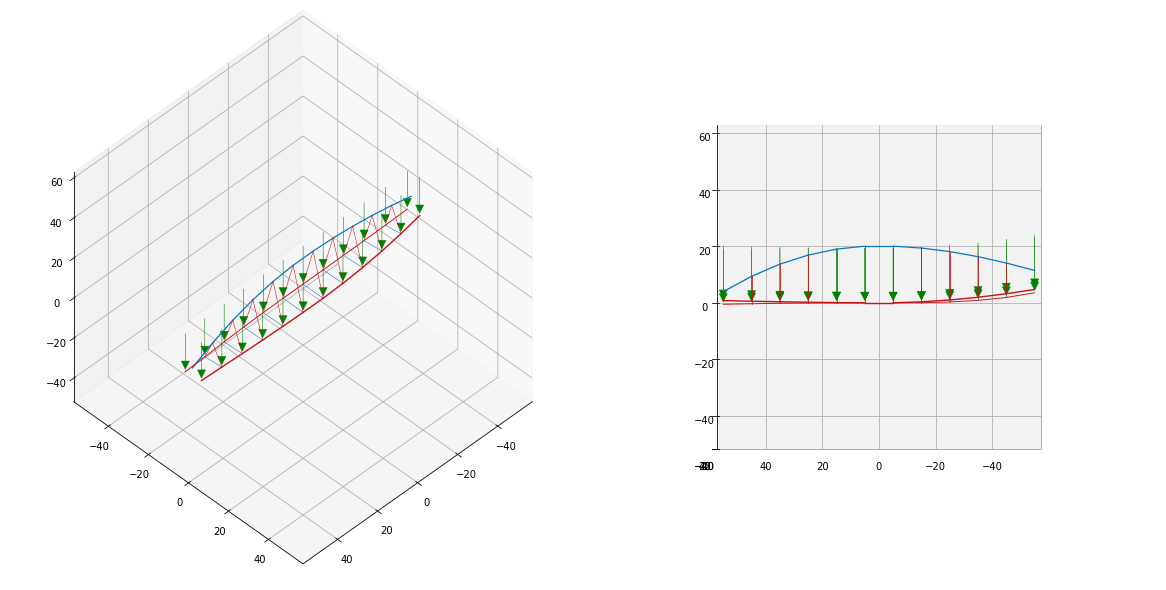

[None, None, None]

In [9]:
Ts = []

for _ in range(3):
    Ts.append(bridge_topology(6,
                              left_dev_mags=[cem_mini.uniform_sampler(-1.5,-0.5), cem_mini.uniform_sampler(0.5, 3)],
                              center_dev_mags=[cem_mini.uniform_sampler(-30,-40), cem_mini.uniform_sampler(20,50)],
                              right_dev_mags=[cem_mini.uniform_sampler(-1.5,-0.5), cem_mini.uniform_sampler(0.5, 3)],
                              height=20))

F_Fcs= [cem_mini.CEM(T,1e-7) for T in Ts]

[plot_bridge(F) for F,Fc in F_Fcs]